### Import packages and libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

  ### Definition of files names


In [ ]:
#labeled set
labels_file = './labeled_set_lc_classifier_SanchezSaez_2020.csv'

#features
features_file = './features_for_lc_classifier_20200609.csv'


### reading the training set files

In [ ]:
df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarding infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['classALeRCE'].values.size)
print(df_feat.head())

123496
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [ ]:
#defining taxonomy tree
df_labels['class_original'] = df_labels['classALeRCE']

#defining the classes

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(123496,)


,class_original,class_hierachical
oid,,
ZTF19aapcxhy,AGN,Stochastic
ZTF18abtmwvo,AGN,Stochastic
ZTF18acvgdfy,AGN,Stochastic
ZTF19aabvjsi,AGN,Stochastic
ZTF18aadyxlg,AGN,Stochastic


In [ ]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',
'iqr_1',
'iqr_2',
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')


df = df.replace([np.inf, -np.inf], np.nan)

df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

df.head()

23666


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aanxuxz,0.095519,-999.000000,0.406445,-999.000000,1.0,-999.0,0.285714,-999.000000,0.0,-999.0,...,0.897857,0.057417,0.677,2.472,-999.000000,-999.000000,8.607105,6.135105,1.253094e-03,-999.000000
ZTF19aaohxwd,0.249306,-999.000000,0.855370,-999.000000,2.0,-999.0,0.375000,-999.000000,0.0,-999.0,...,0.767143,0.026125,0.307,1.876,-999.000000,-999.000000,6.579249,4.703249,4.473370e-09,-999.000000
ZTF19aaoznlm,0.053942,-999.000000,0.214399,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.790000,0.050792,0.816,2.482,-999.000000,-999.000000,8.832290,6.350290,4.857947e+00,-999.000000
ZTF19aauiwtc,0.030440,-999.000000,0.558742,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.962857,0.053417,0.538,2.791,-999.000000,-999.000000,7.660808,4.869808,1.054955e-06,-999.000000
ZTF18aasvvqb,-999.000000,0.152045,-999.000000,0.998849,-999.0,1.0,-999.000000,0.166667,-999.0,0.0,...,0.793333,0.005417,0.821,2.497,7.863539,5.366539,-999.000000,-999.000000,-9.990000e+02,0.000002


In [ ]:
#which are the features included in the model?
print(np.array(df.columns))
print(len(np.array(df.columns)))

['Amplitude_1' 'Amplitude_2' 'AndersonDarling_1' 'AndersonDarling_2'
 'Autocor_length_1' 'Autocor_length_2' 'Beyond1Std_1' 'Beyond1Std_2'
 'Con_1' 'Con_2' 'Eta_e_1' 'Eta_e_2' 'ExcessVar_1' 'ExcessVar_2'
 'GP_DRW_sigma_1' 'GP_DRW_sigma_2' 'GP_DRW_tau_1' 'GP_DRW_tau_2' 'Gskew_1'
 'Gskew_2' 'Harmonics_mag_1_1' 'Harmonics_mag_1_2' 'Harmonics_mag_2_1'
 'Harmonics_mag_2_2' 'Harmonics_mag_3_1' 'Harmonics_mag_3_2'
 'Harmonics_mag_4_1' 'Harmonics_mag_4_2' 'Harmonics_mag_5_1'
 'Harmonics_mag_5_2' 'Harmonics_mag_6_1' 'Harmonics_mag_6_2'
 'Harmonics_mag_7_1' 'Harmonics_mag_7_2' 'Harmonics_mse_1'
 'Harmonics_mse_2' 'Harmonics_phase_2_1' 'Harmonics_phase_2_2'
 'Harmonics_phase_3_1' 'Harmonics_phase_3_2' 'Harmonics_phase_4_1'
 'Harmonics_phase_4_2' 'Harmonics_phase_5_1' 'Harmonics_phase_5_2'
 'Harmonics_phase_6_1' 'Harmonics_phase_6_2' 'Harmonics_phase_7_1'
 'Harmonics_phase_7_2' 'IAR_phi_1' 'IAR_phi_2' 'LinearTrend_1'
 'LinearTrend_2' 'MHPS_high_1' 'MHPS_high_2' 'MHPS_low_1' 'MHPS_low_2'
 'MHPS_rati

In [ ]:
#how many sources belong to each class?
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 250
SNIbc 20
SNII 51
SLSN 7
QSO 5028
AGN 910
Blazar 246
YSO 325
CV/Nova 167
LPV 2675
E 7283
DSCT 142
RRL 6233
CEP 119
Periodic-Other 210


Counter({'E': 7283, 'RRL': 6233, 'QSO': 5028, 'LPV': 2675, 'AGN': 910, 'YSO': 325, 'SNIa': 250, 'Blazar': 246, 'Periodic-Other': 210, 'CV/Nova': 167, 'DSCT': 142, 'CEP': 119, 'SNII': 51, 'SNIbc': 20, 'SLSN': 7})
                number
E                 7283
RRL               6233
QSO               5028
LPV               2675
AGN                910
YSO                325
SNIa               250
Blazar             246
Periodic-Other     210
CV/Nova            167
DSCT               142
CEP                119
SNII                51
SNIbc               20
SLSN                 7


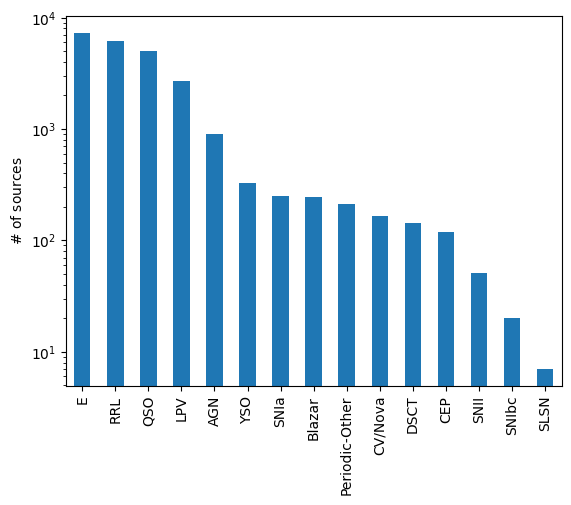

In [ ]:
#plotting the number of sources per class for the labeled set
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')

plt.ylabel(r'$\#$ of sources')

plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')